## Implementation

The Variational Autoencoder will now be implemented and its performance assessed using the MNIST digits and Fashion MNIST datasets.

In [1]:
import random
from collections import defaultdict
from typing import Tuple, Dict, Optional, Callable, Union

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm

ACCELERATOR = 'cuda:0'

if 'cuda' not in ACCELERATOR:
    assert torch.cuda.is_available()

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-igsz_luj because the default path (/home/madzemovic/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


### Dataset

The Torchvision library provides access to the MNIST digits dataset. For further processing, it will be enveloped with transformations such as:
- Conversion from PIL image to torch tensor
- Standardization

The estimated mean for the MNIST dataset is 0.13, and the standard deviation is 0.31. These estimates can be readily verified by computing the mean and std across all pixels in the training dataset.

In [2]:
MNIST_MEAN = 0.13
MNIST_STD = 0.31

def standardize_transform(x: torch.Tensor) -> torch.Tensor:
    """
    Standardizes a given tensor using the precomputed MNIST mean and standard deviation.

    Args:
        x: Input tensor to standardize.

    Returns:
        Standardized tensor.
    """
    return (x - MNIST_MEAN) / MNIST_STD


def standardize_inverse(x: torch.Tensor) -> torch.Tensor:
    """
    Reverses the standardization on a tensor using the precomputed MNIST mean and standard deviation.

    Args:
        x: Input tensor to de-standardize.

    Returns:
        De-standardized tensor.
    """
    return x * MNIST_STD + MNIST_MEAN


class UnsupervisedMNIST(Dataset):
    """
    A class that wraps the MNIST dataset for unsupervised learning. It allows to work with either the Fashion MNIST
    or the original MNIST dataset. This dataset will be used for the Autoencoder and VAE training (in the unsupervised manner).
    """
    def __init__(self, train: bool = True, fashion: bool = False):
        """
        Initializes the dataset object, downloads the dataset and prepares the transform.

        Args:
            train: Whether to load the training split (True) or the test split (False).
            fashion: Whether to load the Fashion MNIST dataset (True) or the original MNIST dataset (False).
        """
        cls = torchvision.datasets.FashionMNIST if fashion else torchvision.datasets.MNIST
        self._mnist = cls(root='/tmp/mnist', train=train, download=True)
        self._to_tensor = transforms.ToTensor()

    def __getitem__(self, i: int) -> Tuple[torch.Tensor, torch.Tensor]:
        raw_img, _ = self._mnist[i]
        img = self._to_tensor(raw_img)
        return standardize_transform(img)

    def __len__(self) -> int:
        return len(self._mnist)

    def label(self, i: int) -> int:
        """
        Returns the label of an image in the dataset at a given index.
        This is only required for the future visualizations.

        Args:
            i: The index of the image for which to return the label.

        Returns:
            The label of the image at the given index.
        """
        return self._mnist[i][1]

    @staticmethod
    def postprocess_image(img: torch.Tensor) -> np.ndarray:
        """
        Performs inverse operation to the data preprocessing. Used for model output inverse.

        Args:
            img: Raw img output

        Returns:
            Postprocessed image.
        """
        img = img.detach().cpu()
        img = standardize_inverse(img)
        img = torch.clip(img, min=0.0, max=1.0)  # clip is necesarry before converting to uint8
        img = img * 255
        img = img.numpy().astype(np.uint8)
        img = img[0]  # Removing channel
        return img
    
    
mnist_example = UnsupervisedMNIST(train=True)
mnist_example[0].shape, mnist_example.label(0)

(torch.Size([1, 28, 28]), 5)

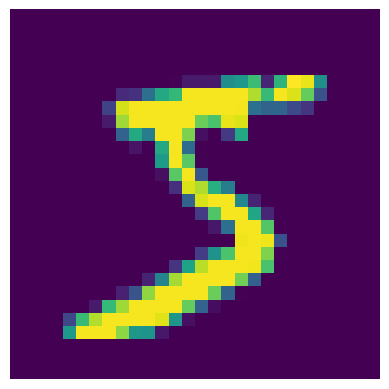

In [3]:
# Helper function for image plotting
def show_image(img: np.ndarray, ax: Optional[plt.Axes] = None) -> None:
    """
    Plots an image.

    Args:
        img: Raw numpy image
        ax: Matplotlib ax (optional)
    """
    if ax is not None:
        ax.imshow(img)
        ax.axis('off')
    else:
        plt.imshow(img)
        plt.axis('off')

show_image(UnsupervisedMNIST.postprocess_image(mnist_example[0]))

## Variational Autoencoder

In this segment, the implementation of the Variational Autoencoder (VAE) model is carried out. Notably, the VAE model retains all capabilities of the Autoencoder (AE) model while also offering additional features such as:

- generating fresh images by sampling from the prior;
- creating new images influenced by an input, by sampling from the posterior;
- performing interpolation over the latent space.

In [8]:
class VariationalAutoEncoder(nn.Module):
    """
    Abstract implementation of VAE model. Requires custom encoder and decoder networks.
    This flexibility allows us to implement MLP and CNN VAE variants while keeping the same interface.
    """
    def __init__(self, encoder: nn.Module, decoder: nn.Module):
        """
        Args:
            input_size: Tensor input size (default is 784 for MNIST)
            latent_dim: Latent dimension
        """
        super().__init__()
        self._encoder = encoder
        self._decoder = decoder
        
    def show_encoder_transforms(self, x: torch.Tensor) -> None:
        """
        Prints list of encoder layers and output shapes. Useful for debugging and model validation.

        Args:
            x: Random input (with shape 1, 28, 28)
        """
        print('---Encoder transforms---')
        print(f'Input shape: {x.shape}')
        for i, layer in enumerate(self._encoder):
            layer_name = type(layer).__name__
            x = layer(x)
            print(f'[{i+1}] name={layer_name}, shape={x.shape}')

    def show_decoder_transforms(self, x: torch.Tensor) -> None:
        """
        Prints list of encoder layers and output shapes. Useful for debugging and model validation.

        Args:
            x: Random input (with shape 1, 28, 28)
        """
        print('---Decoder transforms---')
        print(f'[0] Input shape: {x.shape}')
        for i, layer in enumerate(self._decoder):
            layer_name = type(layer).__name__
            x = layer(x)
            print(f'[{i+1}] name={layer_name}, shape={x.shape}')
        print()
            
    def forward(self, x: torch.Tensor, sample: bool = True) -> Dict[str, torch.Tensor]:
        z_all = self._encoder(x)
        z_mean, z_log_var = z_all[..., :self._latent_dim], z_all[..., self._latent_dim:]
        
        if sample:
            z_std = torch.sqrt(torch.exp(z_log_var))
            e = torch.randn_like(z_mean)
            z = z_mean + z_std * e 
        else:
            z = z_mean
            
        x_hat = self._decoder(z)
        return {
            'x': x_hat,
            'z': z,
            'z_mean': z_mean,
            'z_log_var': z_log_var
        }
    
    def sample_from_prior(self) -> torch.Tensor:
        """
        Generates a sample from the prior distribution and decodes it into data space.

        Returns:
            The generated data sample.
        """
        device = next(self.parameters()).device
        z = torch.randn(1, self._latent_dim).to(device)   # Generate a latent variable from the standard normal distribution
        return self._decoder(z)[0]
    
    def sample_from_posterior(self, x_evidence: torch.Tensor) -> torch.Tensor:
        """
        Generates a sample from the posterior distribution conditioned on evidence and decodes it into data space.

        Args:
            x_evidence: The evidence to condition the posterior distribution on.

        Returns:
            The generated data sample.
        """
        x_evidence = x_evidence.unsqueeze(0)  # Adding pseudo batch dimension
        # Sampling from the posterior distribution of the latent variable given the observed data
        output = self.forward(x_evidence, sample=True) 
        return output['x'][0]  # Removing batch dimension


class MLPVariationalAutoEncoder(VariationalAutoEncoder):
    def __init__(self, image_shape: Tuple[int, int, int] = (1, 28, 28), latent_dim: int = 2):
        """
        Args:
            input_size: Tensor input size (default is 784 for MNIST)
            latent_dim: Latent dimension
        """
        image_flat_size = image_shape[0] * image_shape[1] * image_shape[2]

        encoder = nn.Sequential(
            nn.Flatten(start_dim=-3),  # size: 28*28 = 784
            nn.Linear(image_flat_size, 392),
            nn.ReLU(),
            nn.Linear(392, 196),
            nn.ReLU(),
            nn.Linear(196, 2 * latent_dim)
        )
    
        decoder = nn.Sequential(
            nn.Linear(latent_dim, 196),
            nn.ReLU(),
            nn.Linear(196, 392),
            nn.ReLU(),
            nn.Linear(392, image_flat_size),
            nn.Unflatten(-1, image_shape)
        )
        
        super().__init__(encoder=encoder, decoder=decoder)
        self._latent_dim = latent_dim

    
vae = MLPVariationalAutoEncoder()
vae.show_encoder_transforms(torch.randn(1, 28, 28, dtype=torch.float32))
vae.show_decoder_transforms(torch.randn(2, dtype=torch.float32))
output = vae(torch.randn(1, 28, 28, dtype=torch.float32))
{k: v.shape for k, v in output.items()}

---Encoder transforms---
Input shape: torch.Size([1, 28, 28])
[1] name=Flatten, shape=torch.Size([784])
[2] name=Linear, shape=torch.Size([392])
[3] name=ReLU, shape=torch.Size([392])
[4] name=Linear, shape=torch.Size([196])
[5] name=ReLU, shape=torch.Size([196])
[6] name=Linear, shape=torch.Size([4])
---Decoder transforms---
[0] Input shape: torch.Size([2])
[1] name=Linear, shape=torch.Size([196])
[2] name=ReLU, shape=torch.Size([196])
[3] name=Linear, shape=torch.Size([392])
[4] name=ReLU, shape=torch.Size([392])
[5] name=Linear, shape=torch.Size([784])
[6] name=Unflatten, shape=torch.Size([1, 28, 28])



{'x': torch.Size([1, 28, 28]),
 'z': torch.Size([2]),
 'z_mean': torch.Size([2]),
 'z_log_var': torch.Size([2])}

#### Training VAE

The training process for the VAE tends to be more time-consuming than for the AE due to its inherent stochastic nature.

In [9]:
class GaussianELBOLoss(nn.Module):
    """
    Computes the ELBO loss for a multivariate Gaussian distribution with a diagonal covariance matrix.
    """
    def __init__(self, noise: float):
        """
        Args:
            noise: Value of the covariance matrix, a constant.
                Increasing this value enhances the regularization effect.
        """
        super().__init__()
        self._noise = noise
        
    def forward(self, x_hat: torch.Tensor, x_target: torch.Tensor, z_mean: torch.Tensor, z_log_var: torch.Tensor) -> torch.Tensor:
        likelihood_loss = torch.mean(1 / (2 * self._noise) * torch.sum(torch.square(x_hat - x_target), dim=-1))
        z_var = torch.exp(z_log_var)
        kl_loss = torch.mean(- 1/2 * torch.sum(1 + z_log_var / 2 - z_var - torch.square(z_mean), dim=-1))
        return likelihood_loss + kl_loss, likelihood_loss, kl_loss

In [10]:
def train_variational_autoencoder(
    model: VariationalAutoEncoder,
    train_dataset: Dataset,
    val_dataset: Dataset,
    vae_noise: float = 0.1,
    epochs: int = 40,
    base_learning_rate: float = 1e-3,
    scheduler_step_size: int = 20,
    batch_size: int = 64,
    num_workers = 2,
    accelerator: str = 'cpu'
) -> dict:
    """
    Trains the Variational AutoEncoder (VAE) model and returns the training history.

    Args:
        model: The VariationalAutoEncoder model to be trained.
        train_dataset: The dataset used for training.
        val_dataset: The dataset used for validation during training.
        vae_noise: VAE noise hyperparameter - higher value -> stronger regularization
        epochs: The number of epochs to train the model. Default is 20.
        base_learning_rate: Base (starting) learning rate
        scheduler_step_size: The number of epochs after which the scheduler decreases the learning rate. Default is 10.
        batch_size: The size of the batches used for training and validation. Default is 64.
        num_workers: The number of worker threads used with the DataLoader. Default is 2.
        accelerator: The device to perform operations. Default is 'cpu'. Options are 'cpu' or 'cuda' if GPU is available.

    Returns:
        A dictionary containing the training history, including training and validation loss per epoch.
    """
    loss_func = GaussianELBOLoss(noise=vae_noise)
    model.to(accelerator)
    optimizer = torch.optim.Adam(lr=base_learning_rate, params=model.parameters())
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = scheduler_step_size)
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers)
    val_dataloader = DataLoader(val_dataset, batch_size, num_workers=num_workers, shuffle=True)
    
    history = defaultdict(list)
    
    for epoch in tqdm(range(1, epochs+1)):
        total_loss = 0.0
        total_likelihood_loss = 0.0
        total_kl_loss = 0.0
        n_steps = 0
        
        model.train()
        for img in train_dataloader:
            optimizer.zero_grad()
            
            img = img.to(accelerator)
            output = model(img)
            
            loss, likelihood_loss, kl_loss = loss_func(output['x'], img, output['z_mean'], output['z_log_var'])
            loss.backward()
            optimizer.step()
            
            total_loss += loss.detach().cpu().item()
            total_likelihood_loss += likelihood_loss.detach().cpu().item()
            total_kl_loss += kl_loss.detach().cpu().item()
            n_steps += 1
            
        scheduler.step()
            
        train_loss = total_loss / n_steps
        train_likelihood_loss = total_likelihood_loss / n_steps
        train_kl_loss = total_kl_loss / n_steps
        
        total_loss = 0.0
        total_likelihood_loss = 0.0
        total_kl_loss = 0.0
        n_steps = 0
        
        model.eval()
        with torch.no_grad():
            for img in val_dataloader:
                img = img.to(accelerator)
                output = model(img)

                loss, likelihood_loss, kl_loss = loss_func(output['x'], img, output['z_mean'], output['z_log_var'])
                
                total_loss += loss.detach().cpu().item()
                total_likelihood_loss += likelihood_loss.detach().cpu().item()
                total_kl_loss += kl_loss.detach().cpu().item()
                n_steps += 1
                
        val_loss = total_loss / n_steps
        val_likelihood_loss = total_likelihood_loss / n_steps
        val_kl_loss = total_kl_loss / n_steps
        
        print(f'[Epoch={epoch:02d}]: train_loss={train_loss:.2f}, val_loss={val_loss:.2f}')
        
        history['train_loss'].append(train_loss)
        history['train_likelihood_loss'].append(train_likelihood_loss)
        history['train_kl_loss'].append(train_kl_loss)
        history['val_loss'].append(val_loss)
        history['val_likelihood_loss'].append(val_likelihood_loss)
        history['val_kl_loss'].append(val_kl_loss)
        history['epoch'].append(epoch)
        
    return dict(history)
        

vae = MLPVariationalAutoEncoder()
history = train_variational_autoencoder(
    model=vae,
    train_dataset=UnsupervisedMNIST(train=True),
    val_dataset=UnsupervisedMNIST(train=False),
    accelerator=ACCELERATOR
)

  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch=01]: train_loss=76.02, val_loss=72.31
[Epoch=02]: train_loss=66.73, val_loss=68.54
[Epoch=03]: train_loss=63.93, val_loss=65.57
[Epoch=04]: train_loss=62.52, val_loss=65.03
[Epoch=05]: train_loss=61.39, val_loss=64.25
[Epoch=06]: train_loss=60.81, val_loss=62.52
[Epoch=07]: train_loss=60.18, val_loss=62.48
[Epoch=08]: train_loss=59.57, val_loss=62.94
[Epoch=09]: train_loss=59.12, val_loss=61.42
[Epoch=10]: train_loss=58.80, val_loss=60.63
[Epoch=11]: train_loss=58.41, val_loss=60.46
[Epoch=12]: train_loss=58.24, val_loss=60.46
[Epoch=13]: train_loss=58.06, val_loss=60.34
[Epoch=14]: train_loss=58.06, val_loss=59.82
[Epoch=15]: train_loss=57.56, val_loss=59.70
[Epoch=16]: train_loss=57.53, val_loss=58.87
[Epoch=17]: train_loss=57.15, val_loss=59.43
[Epoch=18]: train_loss=57.10, val_loss=59.47
[Epoch=19]: train_loss=57.09, val_loss=59.27
[Epoch=20]: train_loss=57.05, val_loss=58.74
[Epoch=21]: train_loss=55.58, val_loss=55.89
[Epoch=22]: train_loss=55.06, val_loss=55.73
[Epoch=23]

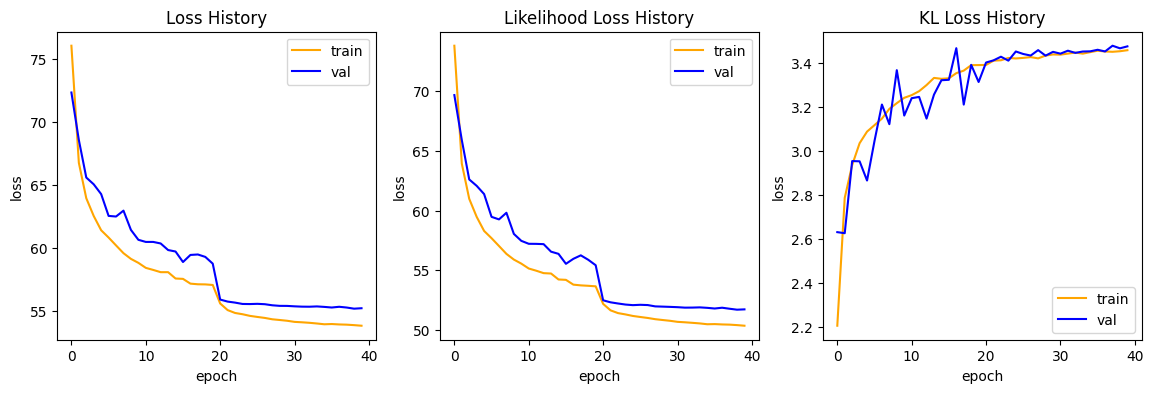

In [11]:
def show_vae_training_history(history: dict) -> None:
    """
    Displays the training history of the Variational Autoencoder (VAE) model.

    Args:
        history: A dictionary containing the training history.
    """

    _, axs = plt.subplots(figsize=(14, 4), ncols=3)
    
    axs[0].plot(history['train_loss'], color='orange', label='train')
    axs[0].plot(history['val_loss'], color='blue', label='val')
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss')
    axs[0].set_title('Loss History')
    axs[0].legend()
    
    axs[1].plot(history['train_likelihood_loss'], color='orange', label='train')
    axs[1].plot(history['val_likelihood_loss'], color='blue', label='val')
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('loss')
    axs[1].set_title('Likelihood Loss History')
    axs[1].legend()
    
    axs[2].plot(history['train_kl_loss'], color='orange', label='train')
    axs[2].plot(history['val_kl_loss'], color='blue', label='val')
    axs[2].set_xlabel('epoch')
    axs[2].set_ylabel('loss')
    axs[2].set_title('KL Loss History')
    axs[2].legend()
    
    plt.show()
    
show_vae_training_history(history)

#### VAE demonstration

##### Reconstruction

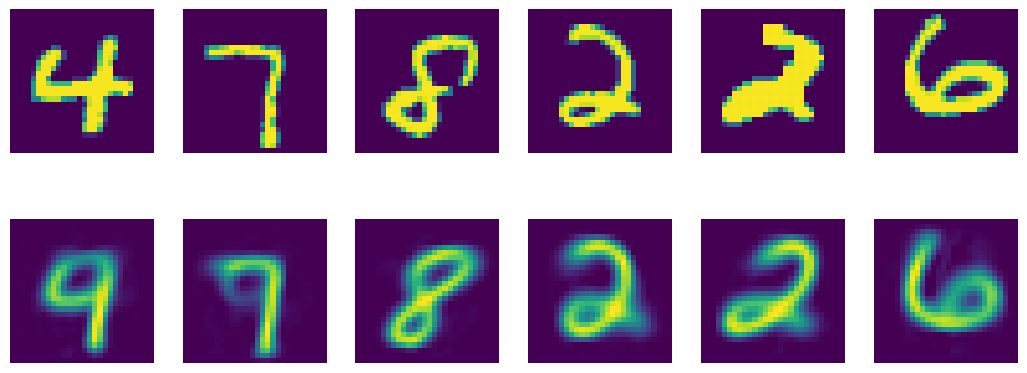

In [12]:
@torch.no_grad()
def show_naive_variational_autoencoder_error_analysis_visualization(
    model: VariationalAutoEncoder,
    val_dataset: Dataset,
    postprocess_image: Callable[[torch.Tensor], np.ndarray],
    accelerator: str = 'cpu'
) -> None:
    """
    Displays a naive visualization for error analysis of a VAE.

    Args:
        model: The trained VAE model to use for image reconstruction.
        val_dataset: The dataset to use for generating the visualization. Typically,
            this should be a validation or test dataset.
        postprocess_image: Transforms raw model output to an image.
        accelerator: The device to perform operations. Default is 'cpu'.
            Options are 'cpu' or 'cuda' if GPU is available.
    """
    N_SAMPLES = 6
    indices = list(range(len(val_dataset)))
    sampled_indices = random.choices(indices, k=N_SAMPLES)
    model.to(accelerator)
    
    _, axs = plt.subplots(figsize=(2 * N_SAMPLES + 1, 5), nrows=2, ncols=N_SAMPLES)
    for i in range(N_SAMPLES):
        index = sampled_indices[i]
        img = val_dataset[index]
        img = img.to(accelerator)
        output = model.forward(img)
        img_hat = output['x']
        img, img_hat = [postprocess_image(v) for v in [img, img_hat]]

        show_image(img, ax=axs[0][i])
        show_image(img_hat, ax=axs[1][i])
           
    plt.show()

show_naive_variational_autoencoder_error_analysis_visualization(
    model=vae,
    val_dataset=UnsupervisedMNIST(train=False),
    postprocess_image=UnsupervisedMNIST.postprocess_image,
    accelerator=ACCELERATOR
)

##### Latent space visualization

  0%|          | 0/10000 [00:00<?, ?it/s]

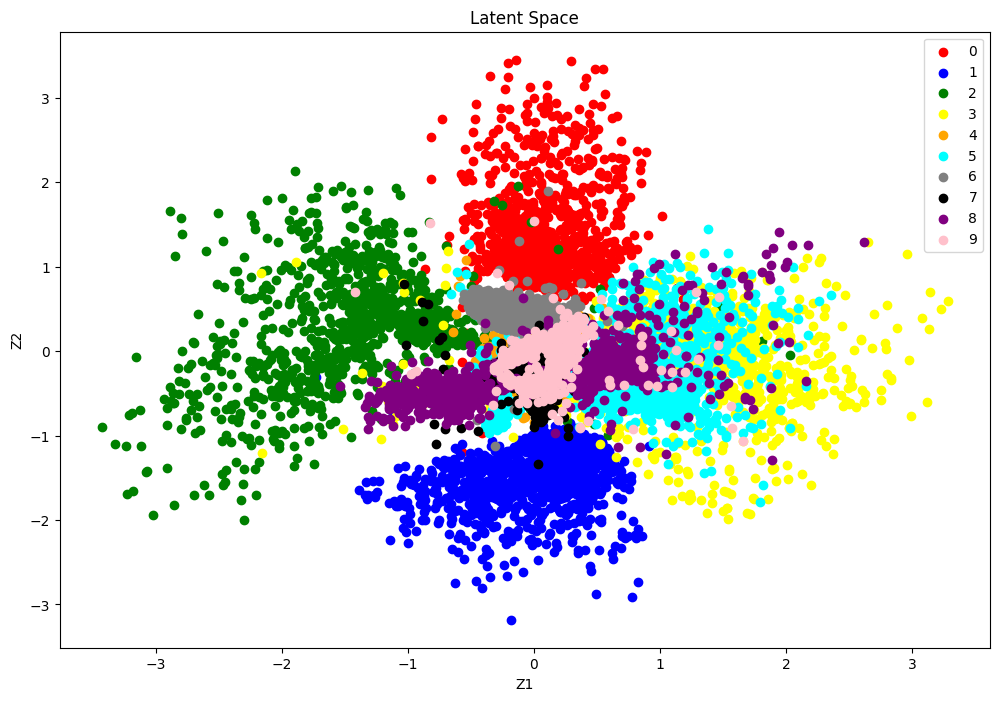

In [13]:
@torch.no_grad()
def show_vae_map_latent_space_distribution_visualization(
    model: VariationalAutoEncoder,
    val_dataset: Dataset,
    accelerator: str = 'cpu'
) -> None:
    """
    Displays the distribution of data in the VAE latent space.

    Args:
        model: The VAE model.
        val_dataset: Dataset used for the visualization.
        accelerator: The device for calculations ('cpu' or 'cuda').
    """
    COLORS = ['red', 'blue', 'green', 'yellow', 'orange', 'cyan', 'gray', 'black', 'purple', 'pink']
    model.eval()
    model.to(accelerator)
    
    zs = defaultdict(list)
    for i in tqdm(range(len(val_dataset))):
        img = val_dataset[i].to(accelerator)
        label = val_dataset.label(i)
        output = model.forward(img.unsqueeze(0), sample=False)
        z = output['z_mean'][0]
        
        zs[label].append(z.detach().cpu())
        
    zs = {k: torch.stack(v) for k, v in zs.items()}
    zs = dict(sorted(zs.items()))
    plt.figure(figsize=(12, 8))
    for i, (label, z) in enumerate(zs.items()):
        z = z.numpy()
        plt.scatter(z[:, 0], z[:, 1], color=COLORS[i], label=str(label))
        
    plt.legend()
    plt.title('Latent Space')
    plt.xlabel('Z1')
    plt.ylabel('Z2')
    plt.show()
    
show_vae_map_latent_space_distribution_visualization(
    model=vae,
    val_dataset=UnsupervisedMNIST(train=False),
    accelerator=ACCELERATOR
)

##### Generating new samples (sampling from the prior)

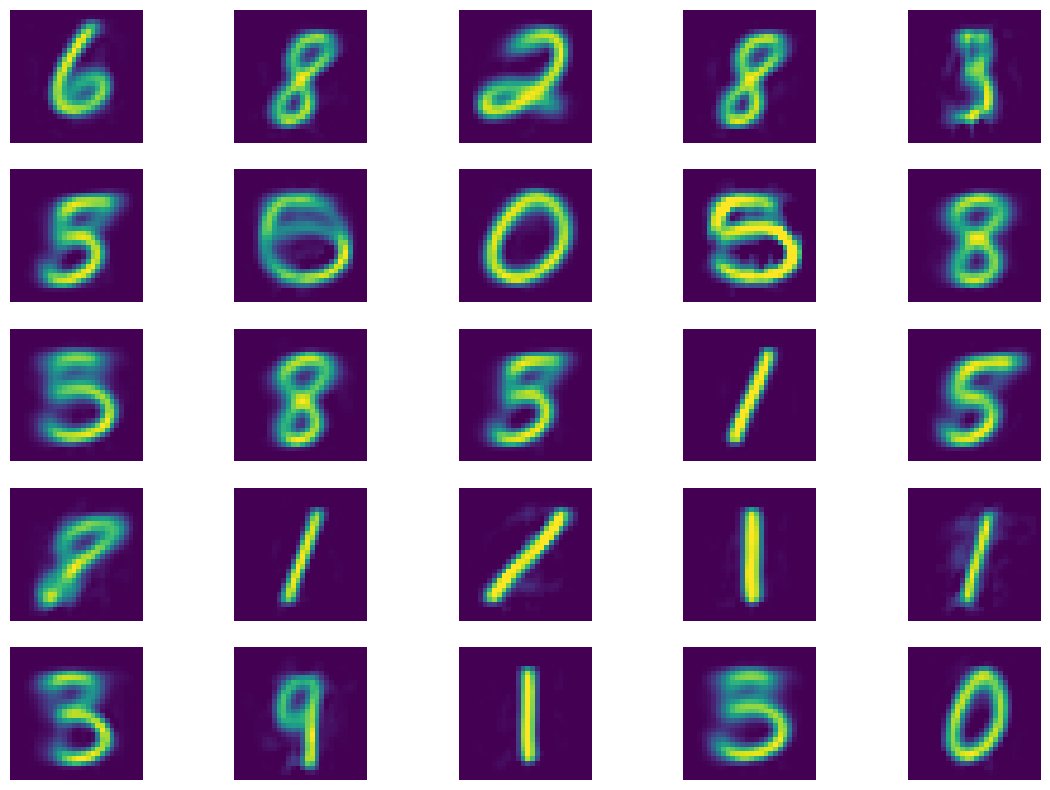

In [14]:
# Sample from prior
def visualize_vae_sampling_from_prior(
    model: VariationalAutoEncoder,
    postprocess_image: Callable[[torch.Tensor], np.ndarray],
    accelerator: str = 'cpu'
) -> None:
    """
    Generates few samples from the VAE prior.

    Args:
        model: The VAE model.
        postprocess_image: Transforms raw model output to an image.
        accelerator: The device for calculations ('cpu' or 'cuda').
    """
    model.to(accelerator)
    model.eval()
    
    _, axs = plt.subplots(figsize=(14, 10), nrows=5, ncols=5)
    for i in range(5):
        for j in range(5):
            ax = axs[i][j]
            img = model.sample_from_prior()
            img = postprocess_image(img)
            show_image(img, ax=ax)
    plt.show()
    
visualize_vae_sampling_from_prior(
    model=vae,
    postprocess_image=UnsupervisedMNIST.postprocess_image,
    accelerator=ACCELERATOR
)

##### Generating new samples similar to the given one (sampling from the posterior)

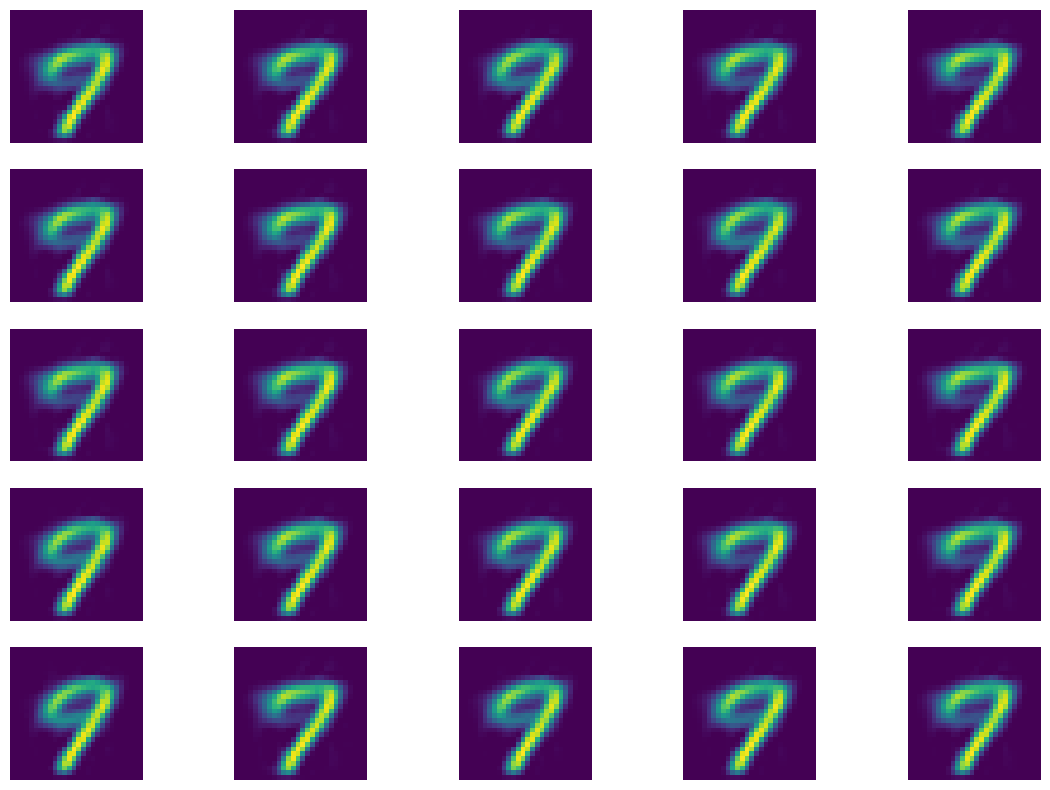

In [15]:
# Sample from posterior
def visualize_vae_sampling_from_posterior(
    model: VariationalAutoEncoder,
    evidence: torch.Tensor,
    postprocess_image: Callable[[torch.Tensor], np.ndarray],
    accelerator: str = 'cpu'
) -> None:
    """
    Generates few samples from the VAE prior.

    Args:
        model: The VAE model.
        evidence: Evidence used to combine with prior to obtain posterior
        postprocess_image: Transforms raw model output to an image.
        accelerator: The device for calculations ('cpu' or 'cuda').
    """
    model.to(accelerator)
    model.eval()
    evidence = evidence.to(accelerator)
    
    _, axs = plt.subplots(figsize=(14, 10), nrows=5, ncols=5)
    for i in range(5):
        for j in range(5):
            ax = axs[i][j]
            img = model.sample_from_posterior(evidence)
            img = postprocess_image(img)
            show_image(img, ax=ax)
    plt.show()
    
visualize_vae_sampling_from_posterior(
    model=vae,
    evidence=UnsupervisedMNIST(train=False)[7865],
    postprocess_image=UnsupervisedMNIST.postprocess_image,
    accelerator=ACCELERATOR
)

##### Interpolation over the latent space


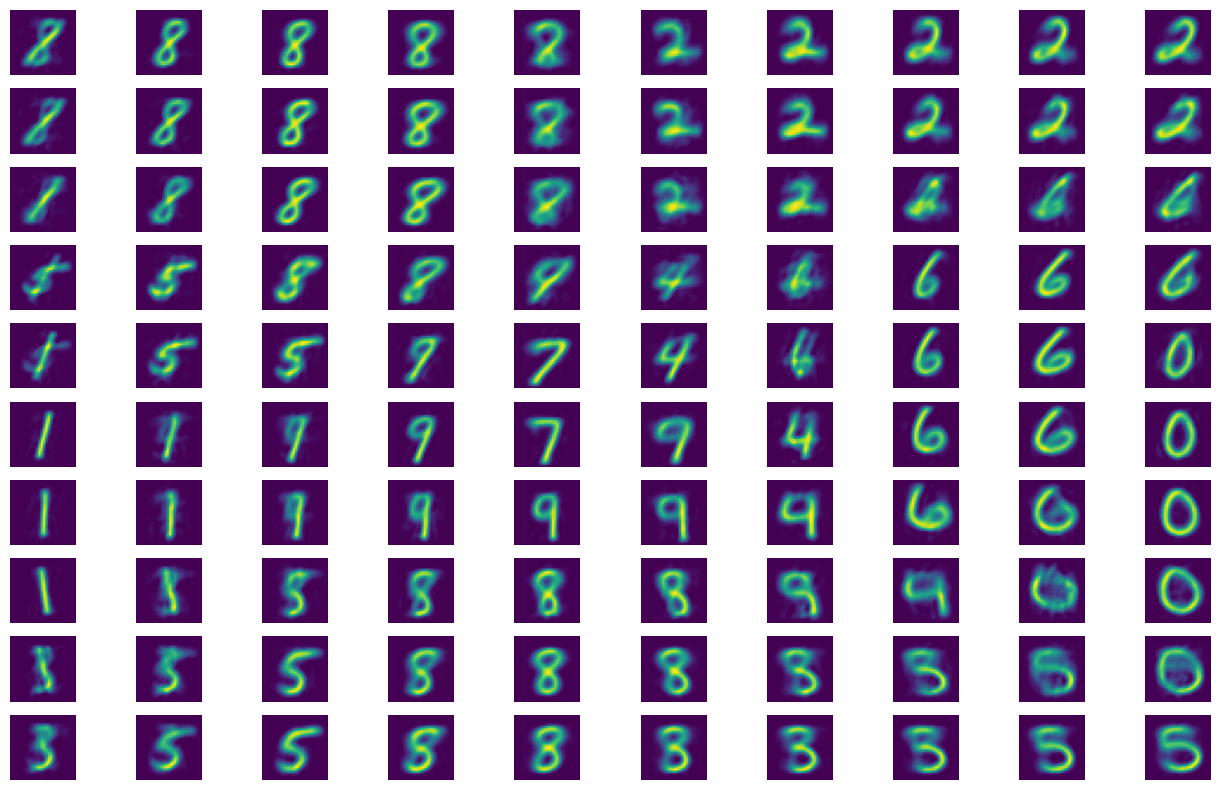

In [16]:
# Interpolation
def vizualize_vae_interpolation(
    model: VariationalAutoEncoder,
    postprocess_image: Callable[[torch.Tensor], np.ndarray],
    accelerator: str = 'cpu'
) -> None:
    model.to(accelerator)
    model.eval()
    
    _, axs = plt.subplots(figsize=(16, 10), nrows=10, ncols=10)
    for i in range(10):
        for j in range(10):
            ax = axs[i][j]
            z = torch.tensor([-1 + 2 * (i / 10), -1 + 2 * (j / 10)], dtype=torch.float32)
            z = z.to(accelerator)
            img = model._decoder(z)
            img = postprocess_image(img)
            show_image(img, ax=ax)
    plt.show()
    
vizualize_vae_interpolation(
    model=vae,
    postprocess_image=UnsupervisedMNIST.postprocess_image,
    accelerator=ACCELERATOR
)